In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import shap
import lime

/home/xiangyu/.conda/envs/PyTc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from skorch import NeuralNetClassifier
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)

In [4]:
type(mnist)

sklearn.utils._bunch.Bunch

> 在神经网络中，Dropout是一种正则化技术，用于减少过拟合。它通过在训练过程中随机将一些神经元的输出设置为零来实现。dropout参数是指在Cnn模型中的dropout层中应用的丢弃比例。在给定的dropout层中，丢弃比例决定了要丢弃的神经元的比例，通常在0和1之间取值。较高的丢弃比例意味着更多的神经元将被丢弃，从而增加了模型的鲁棒性和泛化能力，但可能会降低模型的拟合能力。

In [5]:
# Train a CNN to classify MNIST
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

> 这段代码是一个示例，展示了如何使用NeuralNetClassifier类来构建一个分类器模型。在这个示例中，首先使用torch.manual_seed(0)设置随机种子，以确保结果的可重复性。
> 然后创建了一个NeuralNetClassifier对象cnn，并传入了一些参数，包括模型类Cnn、最大训练轮数max_epochs、学习率lr、优化器optimizer和设备device。接下来调用cnn.initialize()方法来初始化模型的各个组件，然后使用cnn.load_params()方法加载预训练的参数。
> 总的来说，这段代码展示了如何使用NeuralNetClassifier类来构建和初始化一个分类器模型，并加载预训练的参数。

In [6]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=20,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)
# Load pretrained parameters
cnn.initialize()
cnn.load_params(f_params='./MINST.pkl')

In [7]:
#Define the level sets of BHEM
from itertools import chain, combinations

def all_subsets(t):
    return tuple(chain.from_iterable(combinations(t, r) for r in range(len(t) + 1)))

In [8]:
Feature_5 = np.zeros((28,28),dtype = int)
for k in range(28*28):
  row = k//28
  column = k%28
  Feature_5[row, column] = k
Index_5 = tuple(np.unique(Feature_5))

Feature_4 = np.zeros((28,28),dtype = int)
Hierarchy_45 = {}
Hierarchy_54 = {}
for k in range(1000,1000+14*14):
  t = k - 1000
  row = t//14
  column = t%14
  Feature_4[row*2:(row+1)*2,column*2:(column+1)*2] = k
  temp = np.unique(Feature_5[row*2:(row+1)*2,column*2:(column+1)*2])
  Hierarchy_45[k] = tuple(temp)
  for index in temp:
    Hierarchy_54[index] = k
Index_4 = tuple(np.unique(Feature_4))

Feature_3 = np.zeros((28,28),dtype = int)
Hierarchy_34 = {}
Hierarchy_43 = {}
for k in range(1200,1249):
  t = k - 1200
  row = t//7
  column = t%7
  Feature_3[row*4:(row+1)*4,column*4:(column+1)*4] = k
  temp = np.unique(Feature_4[row*4:(row+1)*4,column*4:(column+1)*4])
  Hierarchy_34[k] = tuple(temp)
  for index in temp:
    Hierarchy_43[index] = k
Index_3 = tuple(np.unique(Feature_3))

Feature_2 = np.zeros((28,28),dtype = int)
Hierarchy_23 = {}
Hierarchy_32 = {}

coord = [[(0,0),(8,0),(20,0)],[(0,8),(8,8),(20,8)],[(0,20),(8,20),(20,20)]]
for k in range(1300,1309):
  t = k - 1300
  row = t//3
  column = t%3
  ars,acs = coord[row][column]
  cspace = 8
  if row == 1:
    cspace = 12
  rspace = 8
  if column == 1:
    rspace = 12

  Feature_2[ars:ars+rspace, acs:acs+cspace] = k
  temp = np.unique(Feature_3[ars:ars+rspace, acs:acs+cspace])
  Hierarchy_23[k] = tuple(temp)
  for index in temp:
    Hierarchy_32[index] = k

Index_2 = tuple(np.unique(Feature_2))

Feature_1 = np.zeros((28,28),dtype = int)
Hierarchy_12 = {}
Hierarchy_21 = {}

Feature_1[:,0:8] = 1400
temp = np.unique(Feature_2[:,0:8])
Hierarchy_12[1400] = tuple(temp)
for index in temp:
  Hierarchy_21[index] = 1400

Feature_1[:,8:20] = 1401
temp = np.unique(Feature_2[:,8:20])
Hierarchy_12[1401] = tuple(temp)
for index in temp:
  Hierarchy_21[index] = 1401

Feature_1[:,20:28] = 1402
temp = np.unique(Feature_2[:,20:28])
Hierarchy_12[1402] = tuple(temp)
for index in temp:
  Hierarchy_21[index] = 1402

Index_1 = tuple(np.unique(Feature_1))

`Feature_5`: 28\*28，单位块大小为 1\*1，共 28\*28 块，0-783

`Feature_4`: 28\*28，单位块大小为 2\*2，共 14\*14 块，1000-1195

`Feature_3`: 28\*28，单位块大小为 4\*4，共 7\*7 块，1200-1248

`Feature_2`: 28\*28，单位块大小为 (8+12+8)\*(8+12+8)，共 3\*3 块，1300-1308

`Feature_1`: 28\*28，单位块大小为 28\*8+28\*12+28\*8，共 1\*3 块，1400-1402

`Hierarchy_ab`: dict{`Feature_a` 中的值: [`Feature_b` 中对应位置上的值]}

`Index_n`: `Feature_n` 中的元素，去掉重复值

In [9]:
Index_1

(1400, 1401, 1402)

In [10]:
print(f"{Hierarchy_12}\n{Hierarchy_23}\n{Hierarchy_34}")

{1400: (1300, 1301, 1302), 1401: (1303, 1304, 1305), 1402: (1306, 1307, 1308)}
{1300: (1200, 1201, 1207, 1208), 1301: (1214, 1215, 1221, 1222, 1228, 1229), 1302: (1235, 1236, 1242, 1243), 1303: (1202, 1203, 1204, 1209, 1210, 1211), 1304: (1216, 1217, 1218, 1223, 1224, 1225, 1230, 1231, 1232), 1305: (1237, 1238, 1239, 1244, 1245, 1246), 1306: (1205, 1206, 1212, 1213), 1307: (1219, 1220, 1226, 1227, 1233, 1234), 1308: (1240, 1241, 1247, 1248)}
{1200: (1000, 1001, 1014, 1015), 1201: (1002, 1003, 1016, 1017), 1202: (1004, 1005, 1018, 1019), 1203: (1006, 1007, 1020, 1021), 1204: (1008, 1009, 1022, 1023), 1205: (1010, 1011, 1024, 1025), 1206: (1012, 1013, 1026, 1027), 1207: (1028, 1029, 1042, 1043), 1208: (1030, 1031, 1044, 1045), 1209: (1032, 1033, 1046, 1047), 1210: (1034, 1035, 1048, 1049), 1211: (1036, 1037, 1050, 1051), 1212: (1038, 1039, 1052, 1053), 1213: (1040, 1041, 1054, 1055), 1214: (1056, 1057, 1070, 1071), 1215: (1058, 1059, 1072, 1073), 1216: (1060, 1061, 1074, 1075), 1217: (10

In [11]:
SEG_PIXELS = {}
for i in Index_1:
  SEG_PIXELS[i] = np.where(Feature_1==i)  # 
for i in Index_2:
  SEG_PIXELS[i] = np.where(Feature_2==i)
for i in Index_3:
  SEG_PIXELS[i] = np.where(Feature_3==i)
for i in Index_4:
  SEG_PIXELS[i] = np.where(Feature_4==i)
for i in Index_5:
  SEG_PIXELS[i] = np.where(Feature_5==i)

In [12]:
SEG_PIXELS

{1400: (array([ 0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  2,
          2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
          8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
         10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12,
         12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14,
         14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
         17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19,
         19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21,
         21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23,
         23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25,
         25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 2

In [13]:
print(SEG_PIXELS.keys())

dict_keys([1400, 1401, 1402, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103,

In [14]:
Index_1[0], Index_1[1], Index_1[2]

(1400, 1401, 1402)

In [15]:
Hierarchy_23[1300]

(1200, 1201, 1207, 1208)

In [16]:
def mask_image(segpatches, img):
    out = np.ones_like(img) * 0.0
    if len(segpatches) == 0:
      return out
    for i in segpatches:
      #print(i)
      out[SEG_PIXELS[i]] = img[SEG_PIXELS[i]]
    return out


def GenerateHES3(explained_Image, explained_Label, batch_size = 100):
  buffer = []
  values = []
  set2number = {}
  value_set = {}
  count = 0
  for f1 in Index_1:  # [1400], 1401, 1402
    lower_2 = Hierarchy_12[f1] # [(1300, 1301, 1302)], (1303, 1304, 1305), (1306, 1307, 1308)
    for f2 in lower_2:  # [1300], 1301, 1302
      lower_3 = Hierarchy_23[f2]  # [(1200, 1201, 1207, 1208)]
      #print(lower_2, lower_3)

      t1 = list(Index_1)
      t1.remove(f1)
      t2 = list(lower_2)
      t2.remove(f2)
      t3 = list(lower_3)
      total = tuple(t1+t2+t3)

      for subset in all_subsets(total):
        if frozenset(subset) in set2number:
          continue
        else:
          set2number[frozenset(subset)] = count
          count += 1
          masked_img = mask_image(subset,explained_Image)
          buffer.append(masked_img.reshape(1, 1, 28, 28))

          if len(buffer) == batch_size:
            batch = np.concatenate(buffer,axis=0)
            probs = cnn.predict_proba(batch)[:, explained_Label]
            buffer = []
            values.extend(probs)

      batch = np.concatenate(buffer,axis=0)
      probs = cnn.predict_proba(batch)[:, explained_Label]
      buffer = []
      values.extend(probs)

  for keys in set2number:
    value_set[keys] = values[set2number[keys]]

  score_level3_new = {}
  for feature in Index_3:
    #print(feature)
    upper_feature_2 = Hierarchy_32[feature]
    upper_feature_1 = Hierarchy_21[upper_feature_2]
    #print(upper_feature_2, upper_feature_1)
    brother_features_3 = Hierarchy_23[upper_feature_2]
    brother_features_2 = Hierarchy_12[upper_feature_1]
    #print(brother_features_3, brother_features_2)

    t1 = list(Index_1)
    t1.remove(upper_feature_1)
    t2 = list(brother_features_2)
    t2.remove(upper_feature_2)
    t3 = list(brother_features_3)
    t3.remove(feature)
    involved_features = tuple(t1 + t2 + t3)
    #print(involved_features)

    score = 0
    for subset in all_subsets(involved_features):
      #print(feature, subset)
      #score += marginal_gain(feature, subset)
      score += value_set[frozenset(subset +(feature,))] - value_set[frozenset(subset)]

    score = score / (2 ** len(involved_features))
    score_level3_new[feature] = score

  return score_level3_new

def GenerateHES4(explained_Image, explained_Label, batch_size = 1000):
  buffer = []
  values = []
  set2number = {}
  value_set = {}
  count = 0
  for f1 in Index_1:            # [1400], 1401, 1402
    lower_2 = Hierarchy_12[f1]      # [(1300, 1301, 1302)], (1303, 1304, 1305), (1306, 1307, 1308)
    for f2 in lower_2:          # [1300], 1301, 1302
      lower_3 = Hierarchy_23[f2]    # [(1200, 1201, 1207, 1208)]
      for f3 in lower_3:        # [1200], 1201, 1207, 1208  
        lower_4 = Hierarchy_34[f3]  # [(1000, 1001, 1014, 1015)]
          #print(lower_2, lower_3)

        t1 = list(Index_1)
        t1.remove(f1)
        t2 = list(lower_2)
        t2.remove(f2)
        t3 = list(lower_3)
        t3.remove(f3)
        t4 = list(lower_4)
        total = tuple(t1+t2+t3+t4)

        for subset in all_subsets(total):
          if frozenset(subset) in set2number:
            continue
          else:
            set2number[frozenset(subset)] = count
            count += 1
            masked_img = mask_image(subset,explained_Image)
            buffer.append(masked_img.reshape(1, 1, 28, 28))

            if len(buffer) == batch_size:
              batch = np.concatenate(buffer,axis=0)
              probs = cnn.predict_proba(batch)[:, explained_Label]
              buffer = []
              values.extend(probs)

        batch = np.concatenate(buffer,axis=0)
        probs = cnn.predict_proba(batch)[:, explained_Label]
        buffer = []
        values.extend(probs)

  for keys in set2number:
    value_set[keys] = values[set2number[keys]]

  score_level_new = {}
  for feature in Index_4:
    #print(feature)
    upper_feature_3 = Hierarchy_43[feature]
    upper_feature_2 = Hierarchy_32[upper_feature_3]
    upper_feature_1 = Hierarchy_21[upper_feature_2]
    #print(upper_feature_2, upper_feature_1)
    brother_features_4 = Hierarchy_34[upper_feature_3]
    brother_features_3 = Hierarchy_23[upper_feature_2]
    brother_features_2 = Hierarchy_12[upper_feature_1]
    #print(brother_features_3, brother_features_2)

    t1 = list(Index_1)
    t1.remove(upper_feature_1)
    t2 = list(brother_features_2)
    t2.remove(upper_feature_2)
    t3 = list(brother_features_3)
    t3.remove(upper_feature_3)
    t4 = list(brother_features_4)
    t4.remove(feature)
    involved_features = tuple(t1 + t2 + t3 + t4)
    #print(involved_features)

    score = 0
    for subset in all_subsets(involved_features):
      #print(feature, subset)
      #score += marginal_gain(feature, subset)
      score += value_set[frozenset(subset +(feature,))] - value_set[frozenset(subset)]

    score = score / (2 ** len(involved_features))
    score_level_new[feature] = score

  return score_level_new

def GenerateHES5(explained_Image, explained_Label, batch_size = 2000):
  buffer = []
  values = []
  set2number = {}
  value_set = {}
  count = 0
  for f1 in Index_1:
    lower_2 = Hierarchy_12[f1]
    for f2 in lower_2:
      lower_3 = Hierarchy_23[f2]
      for f3 in lower_3:
        lower_4 = Hierarchy_34[f3]
        for f4 in lower_4:
          lower_5 = Hierarchy_45[f4]
          #print(lower_2, lower_3)

          t1 = list(Index_1)
          t1.remove(f1)
          t2 = list(lower_2)
          t2.remove(f2)
          t3 = list(lower_3)
          t3.remove(f3)
          t4 = list(lower_4)
          t4.remove(f4)
          t5 = list(lower_5)
          total = tuple(t1+t2+t3+t4+t5)

          for subset in all_subsets(total):
            if frozenset(subset) in set2number:
              continue
            else:
              set2number[frozenset(subset)] = count
              count += 1
              masked_img = mask_image(subset,explained_Image)
              buffer.append(masked_img.reshape(1, 1, 28, 28))

              if len(buffer) == batch_size:
                batch = np.concatenate(buffer,axis=0)
                probs = cnn.predict_proba(batch)[:, explained_Label]
                buffer = []
                values.extend(probs)

          batch = np.concatenate(buffer,axis=0)
          probs = cnn.predict_proba(batch)[:, explained_Label]
          buffer = []
          values.extend(probs)

  for keys in set2number:
    value_set[keys] = values[set2number[keys]]

  score_level_new = {}
  for feature in Index_5:
    #print(feature)
    upper_feature_4 = Hierarchy_54[feature]
    upper_feature_3 = Hierarchy_43[upper_feature_4]
    upper_feature_2 = Hierarchy_32[upper_feature_3]
    upper_feature_1 = Hierarchy_21[upper_feature_2]
    #print(upper_feature_2, upper_feature_1)
    brother_features_5 = Hierarchy_45[upper_feature_4]
    brother_features_4 = Hierarchy_34[upper_feature_3]
    brother_features_3 = Hierarchy_23[upper_feature_2]
    brother_features_2 = Hierarchy_12[upper_feature_1]
    #print(brother_features_3, brother_features_2)

    t1 = list(Index_1)
    t1.remove(upper_feature_1)
    t2 = list(brother_features_2)
    t2.remove(upper_feature_2)
    t3 = list(brother_features_3)
    t3.remove(upper_feature_3)
    t4 = list(brother_features_4)
    t4.remove(upper_feature_4)
    t5 = list(brother_features_5)
    t5.remove(feature)
    involved_features = tuple(t1 + t2 + t3 + t4 + t5)
    #print(involved_features)

    score = 0
    for subset in all_subsets(involved_features):
      #print(feature, subset)
      #score += marginal_gain(feature, subset)
      score += value_set[frozenset(subset +(feature,))] - value_set[frozenset(subset)]

    score = score / (2 ** len(involved_features))
    score_level_new[feature] = score

  return score_level_new

In [17]:
#LIME explanation
from lime import lime_image
from IPython.display import clear_output

seg = np.zeros((28,28),dtype = int)
for k in range(0,14*14):
  row = k//14
  column = k%14
  seg[row*2:(row+1)*2,column*2:(column+1)*2] = k
'''
seg = np.zeros((28,28),dtype = int)
for k in range(0,28*28):
  row = k//28
  column = k%28
  seg[row,column] = k
'''

def lime_segments(z):
  return seg

LIME_INDEX = np.unique(seg)
LIME_SEG_PIXELS = {}
for i in LIME_INDEX:
  LIME_SEG_PIXELS[i] = np.where(seg==i)

def lime_predict(z):
  z = z[:, :, :, 0]
  return cnn.predict_proba(z[:,np.newaxis,:,:])

def lmask(contribution):
    mask = np.zeros((28,28),dtype = np.float32)
    for data in contribution:
      index, score = data
      mask[LIME_SEG_PIXELS[index]] = score
    return mask

def get_lime_explaination(images, exlabel):
  explainer = lime_image.LimeImageExplainer()
  explanation = explainer.explain_instance(images, lime_predict, labels=(exlabel,), top_labels=None, num_features=1000, segmentation_fn = lime_segments, num_samples=5000)
  #explanation = explainer.explain_instance(images, lime_predict, hide_color=0, labels=(exlabel,), top_labels=None, num_features=1000, segmentation_fn = lime_segments, num_samples=500) # number of images that will be sent to classification function
  #explanation = explainer.explain_instance(Xsample[1,0], lime_predict, hide_color=0, top_labels=10, num_features=1000, num_samples=500) # number of images that will be sent to classification function
  clear_output(wait=True)
  lime_mask = explanation.local_exp
  temp = lime_mask[exlabel]
  powerlimedict = {}
  for pair in temp:
    powerlimedict[pair[0]] = pair[1]
  #return lmask(temp)
  return powerlimedict

In [18]:
# Shap explanation
def shapPf(z):
  return cnn.predict_proba(z)

masker = shap.maskers.Image("blur(28,28)", (1,28,28))
Pexplainer = shap.Explainer(shapPf, masker)

def get_shap_explaination(images, exlabel):
  shap_Pvalues = Pexplainer(images.reshape(1,1,28,28), max_evals=20000, batch_size=500)
  temp = shap_Pvalues.values[0,0,:,:,exlabel] #(28,28)
  mask = np.zeros((28,28),dtype = np.float32)
  powershapdict = {}
  for k in range(0,14*14):
    row = k//14
    column = k%14
    s = np.mean(temp[row*2:(row+1)*2,column*2:(column+1)*2])
    mask[row*2:(row+1)*2,column*2:(column+1)*2] = s
    powershapdict[k] = s
  #return mask
  return powershapdict

In [19]:
# BHEM explanation
def bhem_mask(contribution, level = Index_4):
    mask = np.zeros((28,28),dtype = np.float32)
    #abs_vals = [abs(i) for i in contribution.values()]
    #max_val = np.max(abs_vals)
    for i in level:
        mask[SEG_PIXELS[i]] = contribution[i]

    return mask

def get_bhem_explaination(images, exlabel):
  score = GenerateHES4(images, exlabel)
  #return bhem_mask(score) # shape(28,28)
  powerbhemdict = {}
  for key in score:
    powerbhemdict[key-1000] = score[key]
  return powerbhemdict

# Robustness

In [20]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
XCnn = X.reshape(-1, 1, 28, 28)
#XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.005, random_state=42)
#XCnn_train.shape, y_train.shape

testnum = 50

Xsample = XCnn[:testnum]
Xlabel = cnn.predict(Xsample)

# Gaussian noise
def add_gsnoise(Xsample, sigma = 0.05):
  Xsample_Gn = Xsample + np.random.normal(0, sigma, Xsample.shape)
  # Clip the pixel values to be between 0 and 255.
  Xsample_Gn = np.clip(Xsample_Gn, 0, 1)
  return Xsample_Gn.astype(np.float32)

# Impulsive noise
def add_psnoise(Xsample, level = 0.05):
  buffer = []
  for i in range(Xsample.shape[0]):
    sample = Xsample[i,0,:,:]
    # Get the image size (number of pixels in the image).
    img_size = sample.size

    # Set the percentage of pixels that should contain noise
    noise_percentage = level  # Setting to 10%

    # Determine the size of the noise based on the noise precentage
    noise_size = int(noise_percentage*img_size)

    # Randomly select indices for adding noise.
    random_indices = np.random.choice(img_size, noise_size)

    # Create a copy of the original image that serves as a template for the noised image.
    Xsample_In = sample.copy()

    # Create a noise list with random placements of min and max values of the image pixels.
    noise = np.random.choice([sample.min(), sample.max()], noise_size)

    # Replace the values of the templated noised image at random indices with the noise, to obtain the final noised image.
    Xsample_In.flat[random_indices] = noise
    buffer.append(Xsample_In.reshape(1, 1, 28, 28))
  return np.concatenate(buffer,axis=0)

In [21]:
print(cnn.predict_proba(Xsample[0,0].reshape(1,1,28,28)))

[[1.6507509e-09 5.9369825e-08 6.6416289e-11 1.3442679e-02 7.8418916e-10
  9.8654050e-01 7.3488446e-09 5.5365682e-08 1.0980272e-06 1.5686845e-05]]


# Plot the compare plots of explanations deleting certain percent of features

0


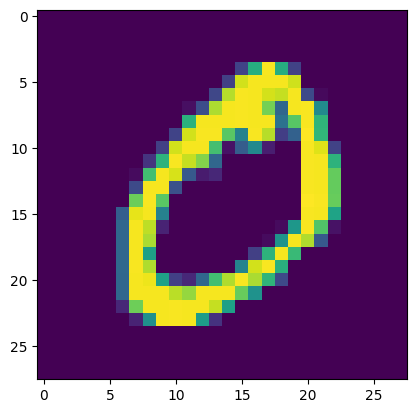

In [22]:
# First, pickup some images
pick = 1
Xtoy = Xsample[pick,0]
toylabel = cnn.predict(Xtoy.reshape(1,1,28,28))[0]
print(toylabel)
plt.imshow(Xtoy)

In [23]:
# Then, compute the explanations, and then sort the features
def getImportantFeature(img, label):
  #print(base_value)
  shapdict = get_shap_explaination(img,label)
  limedict = get_lime_explaination(img,label)
  bhemdict = get_bhem_explaination(img,label)
  shapfeatures = sorted(shapdict, key=lambda k: shapdict[k], reverse=True)
  limefeatures = sorted(limedict, key=lambda k: limedict[k], reverse=True)
  bhemfeatures = sorted(bhemdict, key=lambda k: bhemdict[k], reverse=True)
  return shapfeatures, limefeatures, bhemfeatures

shapfeatures, limefeatures, bhemfeatures = getImportantFeature(Xtoy, toylabel)

100%|██████████| 5000/5000 [00:00<00:00, 5940.48it/s]


(-0.5, 27.5, 27.5, -0.5)

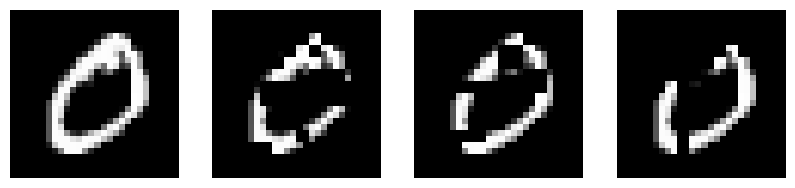

In [24]:
percent = 50
num_select = int(14*14*percent/100)

def reconstruct_mask(features, img):
  out = np.ones_like(img) * 0.0
  if len(features) == 0:
    return out
  for i in features:
    #print(i)
    out[LIME_SEG_PIXELS[i]] = img[LIME_SEG_PIXELS[i]]
  return out

shap_fill = reconstruct_mask(shapfeatures[:num_select],Xtoy)
lime_fill = reconstruct_mask(limefeatures[:num_select],Xtoy)
bhem_fill = reconstruct_mask(bhemfeatures[:num_select],Xtoy)

fig, ax = plt.subplots(1, 4, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(Xtoy, cmap=plt.get_cmap('gray'))
ax[0].axis('off')
#ax[0].set_title('{}'.format(label))
ax[1].imshow(lime_fill, cmap=plt.get_cmap('gray'))
ax[1].axis('off')
#ax[1].set_title('Level-1')
ax[2].imshow(shap_fill, cmap=plt.get_cmap('gray'))
ax[2].axis('off')
ax[3].imshow(bhem_fill, cmap=plt.get_cmap('gray'))
ax[3].axis('off')

In [25]:
LIME_SEG_PIXELS

{0: (array([0, 0, 1, 1]), array([0, 1, 0, 1])),
 1: (array([0, 0, 1, 1]), array([2, 3, 2, 3])),
 2: (array([0, 0, 1, 1]), array([4, 5, 4, 5])),
 3: (array([0, 0, 1, 1]), array([6, 7, 6, 7])),
 4: (array([0, 0, 1, 1]), array([8, 9, 8, 9])),
 5: (array([0, 0, 1, 1]), array([10, 11, 10, 11])),
 6: (array([0, 0, 1, 1]), array([12, 13, 12, 13])),
 7: (array([0, 0, 1, 1]), array([14, 15, 14, 15])),
 8: (array([0, 0, 1, 1]), array([16, 17, 16, 17])),
 9: (array([0, 0, 1, 1]), array([18, 19, 18, 19])),
 10: (array([0, 0, 1, 1]), array([20, 21, 20, 21])),
 11: (array([0, 0, 1, 1]), array([22, 23, 22, 23])),
 12: (array([0, 0, 1, 1]), array([24, 25, 24, 25])),
 13: (array([0, 0, 1, 1]), array([26, 27, 26, 27])),
 14: (array([2, 2, 3, 3]), array([0, 1, 0, 1])),
 15: (array([2, 2, 3, 3]), array([2, 3, 2, 3])),
 16: (array([2, 2, 3, 3]), array([4, 5, 4, 5])),
 17: (array([2, 2, 3, 3]), array([6, 7, 6, 7])),
 18: (array([2, 2, 3, 3]), array([8, 9, 8, 9])),
 19: (array([2, 2, 3, 3]), array([10, 11, 1

# Plot the compare plots of explanations with noises added to images

1


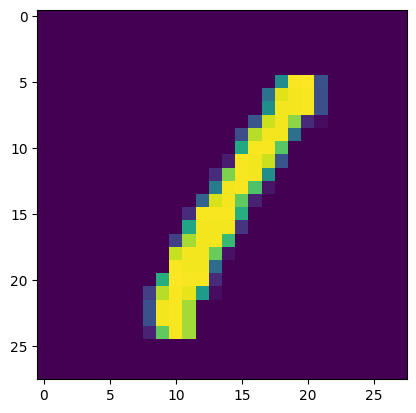

In [26]:
# First, pick up an image.
pick = 3
Xtoy = Xsample[pick,0]
toylabel = cnn.predict(Xtoy.reshape(1,1,28,28))[0]
np.random.seed(0)
Xsample_Gn1 = add_gsnoise(Xsample, sigma = 0.2)
Xsample_In1 = add_psnoise(Xsample, level = 0.05)
Xtoy_gn = Xsample_Gn1[pick,0]
Xtoy_in = Xsample_In1[pick,0]
print(toylabel)
plt.imshow(Xtoy)

In [27]:
# Generate the explanations
SHAP_org = get_shap_explaination(Xtoy,toylabel)
SHAP_gn = get_shap_explaination(Xtoy_gn,toylabel)
SHAP_in = get_shap_explaination(Xtoy_in,toylabel)
LIME_org = get_lime_explaination(Xtoy,toylabel)
LIME_gn = get_lime_explaination(Xtoy_gn,toylabel)
LIME_in = get_lime_explaination(Xtoy_in,toylabel)
BHEM_org = get_bhem_explaination(Xtoy,toylabel)
BHEM_gn = get_bhem_explaination(Xtoy_gn,toylabel)
BHEM_in = get_bhem_explaination(Xtoy_in,toylabel)

100%|██████████| 5000/5000 [00:00<00:00, 5743.91it/s]


In [28]:
LIME_org = get_lime_explaination(Xtoy,toylabel)
LIME_gn = get_lime_explaination(Xtoy_gn,toylabel)
LIME_in = get_lime_explaination(Xtoy_in,toylabel)

100%|██████████| 5000/5000 [00:00<00:00, 5711.78it/s]


(-0.5, 27.5, 27.5, -0.5)

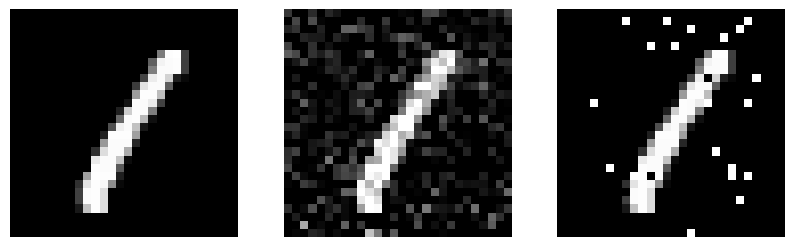

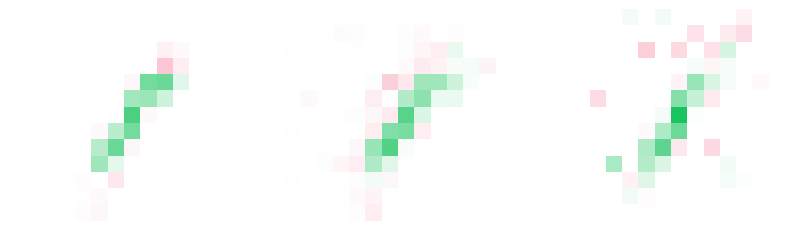

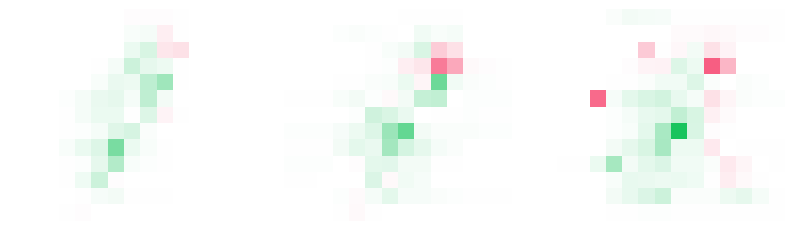

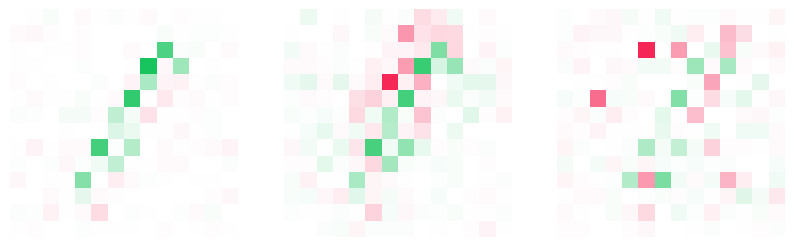

In [29]:
# Plot the comparisons
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(Xtoy, cmap=plt.get_cmap('gray'))
ax[0].axis('off')
#ax[0].set_title('{}'.format(label))
ax[1].imshow(Xtoy_gn, cmap=plt.get_cmap('gray'))
ax[1].axis('off')
#ax[1].set_title('Level-1')
ax[2].imshow(Xtoy_in, cmap=plt.get_cmap('gray'))
ax[2].axis('off')

def create_mask(contribution, level = Index_4):
    mask = np.zeros((28,28),dtype = np.float32)
    #abs_vals = [abs(i) for i in contribution.values()]
    #max_val = np.max(abs_vals)
    for i in level:
      t = i - 1000
      mask[SEG_PIXELS[i]] = contribution[t]

    return mask

Shap_org = create_mask(SHAP_org)
Shap_gn = create_mask(SHAP_gn)
Shap_in = create_mask(SHAP_in)
Lime_org = create_mask(LIME_org)
Lime_gn = create_mask(LIME_gn)
Lime_in = create_mask(LIME_in)
Bhem_org = create_mask(BHEM_org)
Bhem_gn = create_mask(BHEM_gn)
Bhem_in = create_mask(BHEM_in)

Bmax = np.max((np.max(np.abs(Bhem_org)),np.max(np.abs(Bhem_gn)),np.max(np.abs(Bhem_in))))

fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(Bhem_org, cmap=cm, vmin=-Bmax, vmax=Bmax)
ax[0].axis('off')
ax[1].imshow(Bhem_gn, cmap=cm, vmin=-Bmax, vmax=Bmax)
ax[1].axis('off')
ax[2].imshow(Bhem_in, cmap=cm, vmin=-Bmax, vmax=Bmax)
ax[2].axis('off')

Smax = np.max((np.max(np.abs(Shap_org)),np.max(np.abs(Shap_gn)),np.max(np.abs(Shap_in))))

fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(Shap_org, cmap=cm, vmin=-Smax, vmax=Smax)
ax[0].axis('off')
ax[1].imshow(Shap_gn, cmap=cm, vmin=-Smax, vmax=Smax)
ax[1].axis('off')
ax[2].imshow(Shap_in, cmap=cm, vmin=-Smax, vmax=Smax)
ax[2].axis('off')

Lmax1 = np.max(np.abs(Lime_org))
Lmax2 = np.max(np.abs(Lime_gn))
Lmax3 = np.max(np.abs(Lime_in))

fig, ax = plt.subplots(1, 3, figsize=(10, 10), sharex=True, sharey=True)
ax[0].imshow(Lime_org, cmap=cm, vmin=-Lmax1, vmax=Lmax1)
ax[0].axis('off')
#ax[0].set_title('LIME')
ax[1].imshow(Lime_gn, cmap=cm, vmin=-Lmax2, vmax=Lmax2)
ax[1].axis('off')
ax[2].imshow(Lime_in, cmap=cm, vmin=-Lmax3, vmax=Lmax3)
ax[2].axis('off')

# Plot the AOPC curve

In [30]:
def fill_mask(delete, img):
  out = img.copy()
  if len(delete) == 0:
    return out
  for i in delete:
    #print(i)
    out[LIME_SEG_PIXELS[i]] = 0.0
  return out

def calculateAOPC(img, label):
  base_value = cnn.predict_proba(img.reshape(1,1,28,28))[0,label]
  #print(base_value)
  SAOPC = []
  LAOPC = []
  BAOPC = []
  shapdict = get_shap_explaination(img,label)
  limedict = get_lime_explaination(img,label)
  bhemdict = get_bhem_explaination(img,label)
  shapfeatures = sorted(shapdict, key=lambda k: shapdict[k], reverse=True)
  limefeatures = sorted(limedict, key=lambda k: limedict[k], reverse=True)
  bhemfeatures = sorted(bhemdict, key=lambda k: bhemdict[k], reverse=True)
  percentages = [5,10,15,20,25,30,35,40,45,50]
  for per in percentages:
    numdelete = int(49 * per / 100)
    SAOPC.append(base_value - cnn.predict_proba(fill_mask(shapfeatures[:numdelete],img).reshape(1,1,28,28))[0,label])
    LAOPC.append(base_value - cnn.predict_proba(fill_mask(limefeatures[:numdelete],img).reshape(1,1,28,28))[0,label])
    BAOPC.append(base_value - cnn.predict_proba(fill_mask(bhemfeatures[:numdelete],img).reshape(1,1,28,28))[0,label])
  return np.array(SAOPC), np.array(LAOPC), np.array(BAOPC)
  #return np.array(SAOPC), 0, 0

ShapAOPC = np.array([0.0]*10)
LIMEAOPC = np.array([0.0]*10)
BHEMAOPC = np.array([0.0]*10)

for i in range(testnum):
  if (i+1) % 10 == 0:
    print(i)
  img = Xsample[i,0]
  label = Xlabel[i]
  S,L,B = calculateAOPC(img,label)
  ShapAOPC += S
  LIMEAOPC += L
  BHEMAOPC += B

  # 把字典按照value排序，然后拿到排序之后的KEY即可
  # 按照去掉的Key重构image, 计算AOPC
print(ShapAOPC/testnum)
print(LIMEAOPC/testnum)
print(BHEMAOPC/testnum)

[0.06868698 0.18036951 0.33636232 0.45917993 0.57293866 0.65856952
 0.69126312 0.73465232 0.78806916 0.7995256 ]
[0.02461767 0.06227044 0.14552122 0.2389337  0.30398864 0.3060664
 0.41461202 0.44217493 0.46741733 0.48471851]
[0.1195544  0.34089998 0.53504584 0.66921238 0.76908687 0.8241968
 0.87759205 0.90105638 0.92822966 0.93630158]


In [31]:
Sylabel = ShapAOPC/testnum
Bylabel = BHEMAOPC/testnum
Lylabel = LIMEAOPC/testnum
xaxislabel = np.array([5,10,15,20,25,30,35,40,45,50])
print(Bylabel,Lylabel)

[0.1195544  0.34089998 0.53504584 0.66921238 0.76908687 0.8241968
 0.87759205 0.90105638 0.92822966 0.93630158] [0.02461767 0.06227044 0.14552122 0.2389337  0.30398864 0.3060664
 0.41461202 0.44217493 0.46741733 0.48471851]


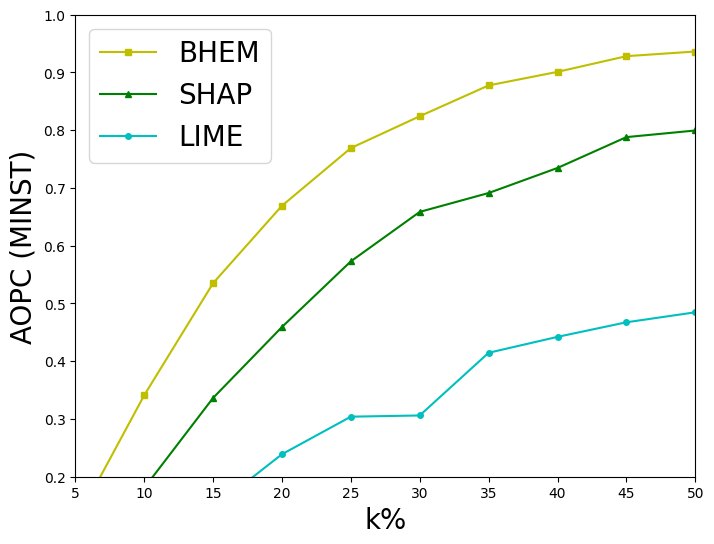

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(xaxislabel,Bylabel,'s-',markersize = 4,color = 'y',label="BHEM")
plt.plot(xaxislabel,Sylabel,'^-',markersize = 4,color = 'g',label="SHAP")
plt.plot(xaxislabel,Lylabel,'o-',markersize = 4,color = 'c',label="LIME")
plt.ylabel("AOPC (MINST)",fontsize = 20)
plt.xlabel("k%",fontsize = 20)
plt.xlim([5,50])
plt.ylim([0.2,1.0])
plt.legend(prop={'size':20})